<a href="https://colab.research.google.com/github/nikhil-sarin/redback/blob/master/examples/RedbackPaperPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redback paper plots
This notebook produces the plots (Fig. 2-9) presented in the Redback paper, **this is not a demonstration of analysis examples**, it is rather a notebook to show the user the plotting functionality and understand the customisable aspects. For details of the analyses you can perform with Redback see the examples [here](https://github.com/nikhil-sarin/redback/tree/master/examples).

The result files required for producing the plots can be found on [Zenodo](https://zenodo.org/record/8273145). By opening this notebook using [Google Colab](https://colab.google/) and uploading the result files to the `/content` file should allow you to run this notebook for start to finish.

Note: The plots produced by default in Redback will look different to the ones in the paper. In cases where the default plotting is very different to the paper plotting, the default plotting example is shown below as well.

## Installations

### Font installs
Getting latex to work.

In [ ]:
!sudo apt-get install texlive-latex-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
!unzip type1cm.zip -d /tmp/type1cm
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!sudo texhash
!apt install cm-super

### Package installs
Installing Redback from source.

In [ ]:
!git clone https://github.com/nikhil-sarin/redback.git
%cd /content/redback
!pip install -r requirements.txt
!pip install .
%cd /content

## Plotting figures

### Importing packages and setting up directory
All plots will be saved in `/content/plots`, this is a temporary directory.

In [ ]:
# Imports and settings

import bilby
import numpy as np
import corner

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18 as cosmo

import redback
from redback.transient_models.afterglow_models import tophat
from redback.simulate_transients import SimulateOpticalTransient

COLOUR_KEY = {
    "pink": "#ff9cc2",
    "red": "#ad0000",
    "orange": "#db8f00",
    "limegreen": "#97eb10",
    "green": "#009667",
    "blue": "#1a41ed",
    "purple":"#bc46eb",
    "violet": "#b58aff",
    }

In [ ]:
# Creates directory to store plots (note that the /content file is a temporary location on Google Colab)

%mkdir /content/plots
%cd /content

### Figure 2a
Simulated kilonova data (using `one_component_kilonova_model`) in ZTF.

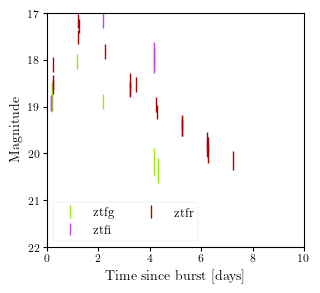

In [5]:
model_kwargs = {}

parameters = redback.priors.get_priors(model='one_component_kilonova_model').sample()
parameters['mej'] = 0.05
parameters['t0_mjd_transient'] = 58288
parameters['redshift'] = 0.005
parameters['t0'] = parameters['t0_mjd_transient']
parameters['temperature_floor'] = 3000
parameters['kappa'] = 1
parameters['vej'] = 0.2

parameters['ra'] = 3.355395
parameters['dec'] = 0.5820673

kn_sim = SimulateOpticalTransient.simulate_transient_in_ztf(
    model='one_component_kilonova_model', survey='ztf',
    parameters=parameters, model_kwargs=model_kwargs,
    end_transient_time=15., snr_threshold=5.,
    add_source_noise=True
    )

kn_sim.save_transient(name='my_kilonova_ztf')
res_kilonova_ztf = redback.transient.Kilonova.from_simulated_optical_data(name='my_kilonova_ztf', data_mode='magnitude')

fig, axes = plt.subplots(1,1, figsize=(3.3,3))
ax = res_kilonova_ztf.plot_data(
    figure=fig, axes=axes,
    show=False, save=False,
    xlim_low=0, xlim_high=10,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=2,
    elinewidth=1,
    band_colors = {
        "ztfg": COLOUR_KEY["limegreen"],
        "ztfr": COLOUR_KEY["red"],
        "ztfi": COLOUR_KEY["purple"],}
    )
ax.set_ylim(22, 17)
fig.savefig(fname="/content/plots/ztf_sim.png", dpi=300, bbox_inches='tight')

### Figure 2b
Simulated kilonova data (using `one_component_kilonova_model`) in LSST.

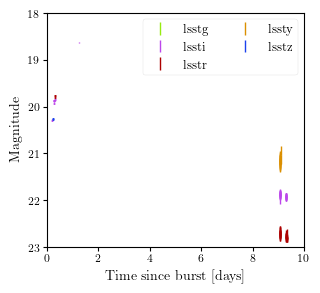

In [6]:
model_kwargs = {}

parameters = redback.priors.get_priors(model='one_component_kilonova_model').sample()
parameters['mej'] = 0.05
parameters['t0_mjd_transient'] = 60250
parameters['redshift'] = 0.01
parameters['t0'] = parameters['t0_mjd_transient']
parameters['temperature_floor'] = 3000
parameters['kappa'] = 1
parameters['vej'] = 0.2
parameters['ra'] = 1.0
parameters['dec'] = -0.5

kn_sim = SimulateOpticalTransient.simulate_transient_in_rubin(
    model='one_component_kilonova_model', survey='Rubin_10yr_baseline',
    parameters=parameters, model_kwargs=model_kwargs,
    end_transient_time=10., snr_threshold=5.
    )

kn_sim.save_transient(name='my_kilonova_lsst')
res_kilonova_lsst = redback.transient.Kilonova.from_simulated_optical_data(name='my_kilonova_lsst', data_mode='magnitude')

fig, axes = plt.subplots(1,1, figsize=(3.3,3))
ax = res_kilonova_lsst.plot_data(
    figure=fig, axes=axes,
    show=False, save=False,
    xlim_low=0, xlim_high=10,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=2,
    elinewidth=1,
    band_colors = {
        "lsstg": COLOUR_KEY["limegreen"],
        "lsstr": COLOUR_KEY["red"],
        "lssti": COLOUR_KEY["purple"],
        "lsstz": COLOUR_KEY["blue"],
        "lssty": COLOUR_KEY["orange"],}
    )
ax.set_ylim(23, 18)
fig.savefig(fname="/content/plots/lsst_sim.png", dpi=300, bbox_inches='tight')

### Figure 3a
Corner plot showing the 1-3 $\sigma$ posterior on a subset of parameters with a GW only analysis and a GW + Afterglow analysis.

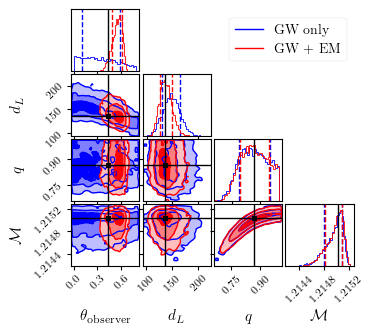

In [7]:
res_gw = bilby.result.read_in_result("/content/gw_only_result.json")
res_gw_em = bilby.result.read_in_result("/content/emgw_result.json")

params = ['theta_jn', 'luminosity_distance', 'mass_ratio', 'chirp_mass']
labels=['$\\theta_{\\mathrm{observer}}$','$d_L$', '$q$', '$\\mathcal{M}$']
injs = [res_gw.injection_parameters[key] for key in params]

data_gw = res_gw.posterior[params].values
data_gw_em = res_gw_em.posterior[params].values

fig, axes = plt.subplots(4,4, figsize=(3.3,3))
corner.corner(
    data_gw, fig=fig, labels=labels, color='b', bins=35, smooth=0.99,
    quantiles=[0.16, 0.84], levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    hist_kwargs=dict(density=True, linewidth=0.6), label_kwargs=dict(fontsize=11),
    plot_density=False, plot_datapoints=False, fill_contours=True,
    alpha=0.5, labelpad=0.4, max_n_ticks=3
    )
corner.corner(
    data_gw_em, fig=fig, labels=labels, color='r', bins=35, smooth=0.99,
    quantiles=[0.16, 0.84], levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    hist_kwargs=dict(density=True, linewidth=0.6), label_kwargs=dict(fontsize=11),
    plot_density=False, plot_datapoints=False, fill_contours=True,
    alpha=0.5, labelpad = 0.4, max_n_ticks=3, truths=injs, truth_color='k'
    )
for ax in fig.get_axes():
  ax.tick_params(axis='both', labelsize=8)

line1 = Line2D([], [], color='b', label='GW only')
line2 = Line2D([], [], color='r', label='GW + EM')
plt.legend(handles=[line1,line2], bbox_to_anchor=(0, 3.2, 1, 1), loc=4, fontsize=10)

fig.savefig(fname="/content/plots/joint_corner.png", dpi=300, bbox_inches='tight')

Default figure plotting method using Bilby

In [8]:
# res_gw = bilby.result.read_in_result("/content/gw_only_result.json")
# res_gw_em = bilby.result.read_in_result("/content/emgw_result.json")

# params = ['theta_jn', 'luminosity_distance', 'mass_ratio', 'chirp_mass']
# injs = [res_gw.injection_parameters[key] for key in params]

# bilby.result.plot_multiple(
#     results=[res_gw,res_gw_em], parameters=params, labels=['GW only','GW + EM'],
#     bins=35, truth=injs, truth_color='k',
#     filename="/content/plots/joint_corner_DEFAULT.png")

### Figure 3b
Lightcurve fit from the joint GW + EM analysis

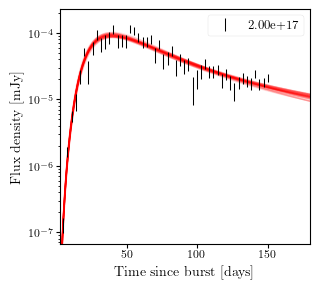

In [9]:
res_gw = bilby.result.read_in_result("/content/gw_only_result.json")
res_gw_em = bilby.result.read_in_result("/content/emgw_result.json")

def get_jet_energy(mass_1, mass_2, fudge):
    total_mass = (mass_1 + mass_2)
    return total_mass * fudge * 2e33 * 3e10**2

def grb_afterglow_model(time, redshift, theta_jn, chirp_mass, mass_ratio, fudge, thc, logn0, p,
                        logepse, logepsb, ksin, g0, **kwargs):
    m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(chirp_mass, mass_ratio)
    energy = get_jet_energy(m1, m2, fudge=fudge)
    energy = np.log10(energy)
    return tophat(time=time, redshift=redshift, thv=theta_jn, loge0=energy, thc=thc,
                  logn0=logn0, p=p, logepse=logepse, logepsb=logepsb,
                  ksin=ksin, g0=g0, **kwargs)

source_redshift = 0.03
source_distance = cosmo.luminosity_distance(source_redshift).value
fudge_factor = 0.04
time = np.linspace(5, 150, 50)

gw_injection_parameters = res_gw.injection_parameters
grb_injection_parameters = dict(
    fudge=fudge_factor,
    theta_jn=gw_injection_parameters['theta_jn'],
    chirp_mass=gw_injection_parameters['chirp_mass'],
    mass_ratio=gw_injection_parameters['mass_ratio'],
    redshift=source_redshift,
    thc=0.1, logn0=0.2, p=2.2, ksin=1,
    logepse=-1, logepsb=-2, g0=1000
    )

afterglow_kwargs = {}
afterglow_kwargs['output_format'] = 'flux_density'
afterglow_kwargs['frequency'] = np.ones(len(time))*2e17

np.random.seed(123)
true_flux = grb_afterglow_model(time, **grb_injection_parameters, **afterglow_kwargs)
yerr = 0.2*true_flux
observed_flux = np.random.normal(true_flux, yerr)

sim_afterglow = redback.transient.Afterglow(
    name='simulated', time=time, flux_density=observed_flux,
    flux_density_err=yerr, data_mode='flux_density',
    frequency=afterglow_kwargs['frequency']
    )

fig, axes = plt.subplots(1,1, figsize=(3.3,3))
ax = redback.analysis.plot_lightcurve(
    transient=sim_afterglow,
    parameters=res_gw_em.posterior.sample(100),
    model=grb_afterglow_model,
    model_kwargs=afterglow_kwargs,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=1,
    elinewidth=0.75, linewidth=1,
    band_colors = {
        2e17:'k',},
    set_same_color_per_subplot=False # uses random_sample_color
    )

fig.savefig(fname="/content/plots/lc.png", dpi=300, bbox_inches='tight')

### Figure 4a
Posterior on the observers viewing angle, the isotropic equivalent energy of the afterglow and the opening angle of the relativistic jet from fitting
the afterglow of GRB170817A with the different shading indicating the 1 to 3 $\sigma$ credible intervals.

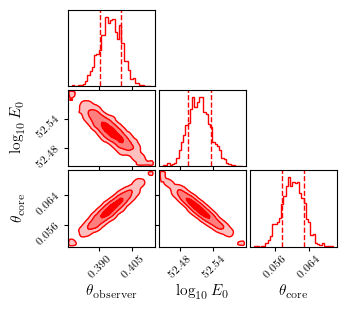

In [10]:
res_GRB170817A = redback.result.read_in_result("/content/GRB170817A_result.json")

params = ['thv', 'loge0', 'thc']
labels = ['$\\theta_{\\mathrm{observer}}$', '$\\log_{10}E_{0}$', '$\\theta_{\\mathrm{core}}$']

data_GRB170817A = res_GRB170817A.posterior[params].values

fig, axes = plt.subplots(3,3, figsize=(3.3,2.9))
corner.corner(
    fig=fig, data=data_GRB170817A, labels=labels, color='r', bins=35, smooth=0.99,
    quantiles=[0.16, 0.84], levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    hist_kwargs=dict(density=True, linewidth=1), label_kwargs=dict(fontsize=11),
    plot_density=False, plot_datapoints=False, fill_contours=True,
    alpha=0.5,  labelpad = 0.2, max_n_ticks=3
    )
for ax in fig.get_axes():
  ax.tick_params(axis='both', labelsize=8)

fig.savefig(fname="/content/plots/GRB170817A_corner.png", dpi=300, bbox_inches='tight')

Default figure plotting method using redback/bilby

In [11]:
# res_GRB170817A = redback.result.read_in_result("/content/GRB170817A_result.json")

# res_GRB170817A.plot_corner(
#     parameters=['thv', 'loge0', 'thc'], bins=35,
#     filename="/content/plots/GRB170817A_corner_DEFAULT.png")

### Figure 4b
Data of the afterglow of GRB170817A at multiple frequencies along with the lightcurves from a 100 random draws from the posterior.

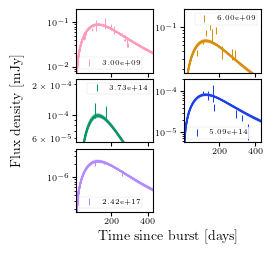

In [12]:
res_GRB170817A = redback.result.read_in_result("/content/GRB170817A_result.json")

ncols = 2
nrows = 3
fig, axes = plt.subplots(nrows,ncols, figsize=(3.3,2.7), sharex='all')

ax = res_GRB170817A.plot_multiband_lightcurve(
    figure=fig, axes=axes,
    show=False, save=False,
    random_models=100,
    fontsize_figure=10,
    fontsize_legend=5,
    fontsize_ticks=6,
    axis_tick_params_pad=1,
    elinewidth=0.75,
    linewidth=1,
    band_colors = {
        3.00e9:  COLOUR_KEY["pink"],
        6.00e9:  COLOUR_KEY["orange"],
        3.73e14: COLOUR_KEY["green"],
        5.09e14: COLOUR_KEY["blue"],
        2.418e17: COLOUR_KEY["violet"],},
    set_same_color_per_subplot = True # overrides max_likelihood color and random_sample_color
    )

if not axes[-1, -1].lines:
  fig.delaxes(axes[-1,-1])
  axes[nrows-2,ncols-1].xaxis.set_tick_params(which='both', labelbottom=True)

fig.subplots_adjust(left=0.22, bottom=0.125, right=0.78, top=0.875, wspace=0.4, hspace=0.1)
fig.savefig(fname="/content/plots/GRB170817A_multiband_lightcurve.png", dpi=300, bbox_inches='tight')

### Figure 5a
Data of AT2017gfo plotted through the `plot_data` method.

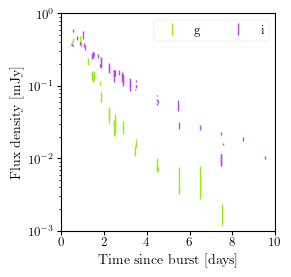

In [13]:
res_at2017gfo = redback.result.read_in_result("/content/at2017gfo_result.json")

fig, axes = plt.subplots(1,1, figsize=(3.3,3))
ax = res_at2017gfo.plot_data(
    figure=fig, axes=axes,
    show=False, save=False, plot_others=False,
    xlim_low=0, xlim_high=10,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=9,
    axis_tick_params_pad=1,
    elinewidth=1,
    band_colors={
        'g': COLOUR_KEY["limegreen"],
        'i': COLOUR_KEY["purple"],}
    )

ax.set_ylim(0.001, 1)
fig.subplots_adjust(left=0.175, bottom=0.125, right=0.825, top=0.85, wspace=0.4, hspace=0.175)
fig.savefig(fname="/content/plots/at2017gfo_data.png", dpi=300, bbox_inches='tight')

### Figure 5b
Data of the AT2017gfo plotted through the `plot_multiband` method.

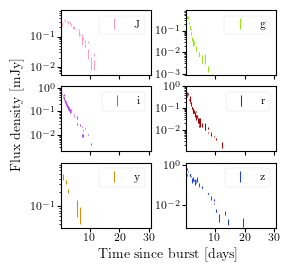

In [14]:
res_at2017gfo = redback.result.read_in_result("/content/at2017gfo_result.json")

fig, axes = plt.subplots(3,2, figsize=(3.3,3), sharex=True)
ax = res_at2017gfo.plot_multiband(
  figure=fig, axes=axes,
  filters=["g", "r", "i", "z", "y", "J"],
  show=False, save=False,
  fontsize_figure=10,
  fontsize_legend=8,
  fontsize_ticks=8,
  axis_tick_params_pad=1,
  elinewidth=0.75,
  band_colors = {
      "g": COLOUR_KEY["limegreen"],
      "r": COLOUR_KEY["red"],
      "i": COLOUR_KEY["purple"],
      "z": COLOUR_KEY["blue"],
      "y": COLOUR_KEY["orange"],
      "J": COLOUR_KEY["pink"],}
  )

fig.subplots_adjust(left=0.175, bottom=0.125, right=0.825, top=0.85, wspace=0.4, hspace=0.175)
fig.savefig(fname="/content/plots/at2017gfo_multiband_data.png", dpi=300, bbox_inches='tight')

### Figure 6
Observations of SN1998bw in R and I bands alongside the 68% credible interval from our fit.

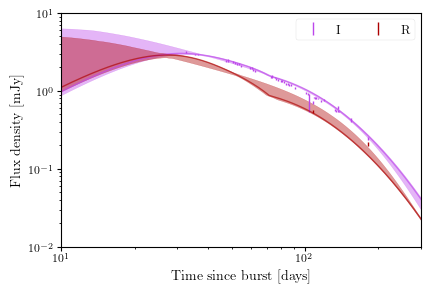

In [15]:
res = redback.result.read_in_result("/content/SN1998bw_result.json")
fig, axes = plt.subplots(1,1, figsize=(4.5,3))
ax = res.plot_lightcurve(
    figure=fig, axes=axes,
    uncertainty_mode='credible_intervals',
    plot_others=False, show=False, save=False,
    credible_interval_level=0.68,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=2,
    elinewidth=1, linewidth=1,
    xlim_high=300, xlim_low=10,
    band_colors = {
      "R": COLOUR_KEY["red"],
      "I": COLOUR_KEY["purple"],},
    set_same_color_per_subplot = True # overrides max_likelihood_color and random_sample_color
    )

ax.set_xscale('log')
ax.set_ylim(0.01, 10)
fig.savefig(fname="/content/plots/sn1998bw.png", dpi=300, bbox_inches='tight')

### Figure 7
Multiband light curve of PS18bh along with the fitted lightcurve from a 100 random realisations randomly drawn from the prior

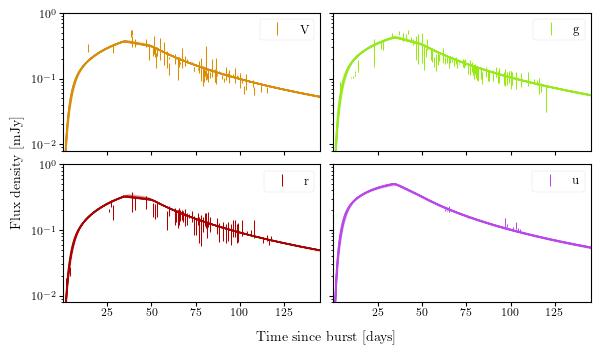

In [16]:
res = redback.result.read_in_result("/content/PS18kh_result.json")

fig, axes = plt.subplots(2,2, figsize=(6.6,3.5),sharex=True, sharey=True)
ax = res.plot_multiband_lightcurve(
    figure=fig, axes=axes,
    show=False, save=False,
    random_models=100,
    filters=["V", "g", "r", "u"],
    fontsize_figure=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=1,
    elinewidth=0.75, linewidth=1,
    band_colors = {
      "g": COLOUR_KEY["limegreen"],
      "r": COLOUR_KEY["red"],
      "u": COLOUR_KEY["purple"],
      "V": COLOUR_KEY["orange"],},
    set_same_color_per_subplot = True # overrides max_likelihood color and random_sample_color
    )
for x in range(len(ax)):
    ax[x].set_ylim(0.008, 1)

fig.subplots_adjust(left=0.1, bottom=0.13, right=0.9, wspace=0.05, hspace=0.1)
fig.savefig(fname="/content/plots/PS18kh_multiband_lightcurve.png", dpi=300, bbox_inches='tight')

### Figure 8
Residual plot obtained using `plot_residual` method of the result object.

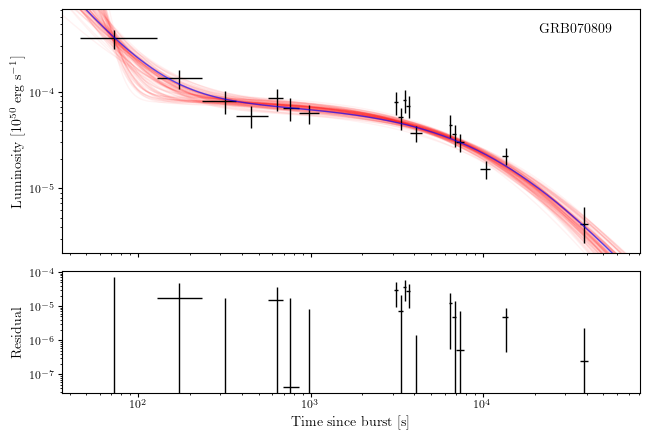

In [17]:
res = redback.result.read_in_result("/content/GRB070809_result.json")

fig, axes = plt.subplots(2,1, figsize=(6.6,4.5),height_ratios=[2, 1], sharex='all')
ax = res.plot_residual(
    figure=fig, axes=axes,
    fontsize_axes=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=2,
    elinewidth=1, linewidth=1,
    annotation_size=10,
    show=False, save=False,)

fig.subplots_adjust(hspace=0.1)
fig.savefig(fname="/content/plots/GRB070809_residual.png", dpi=300, bbox_inches='tight')

### Figure 9
Multiband light curve of SN2018ibb along with the 68% credible interval lightcurve fit from the posterior.

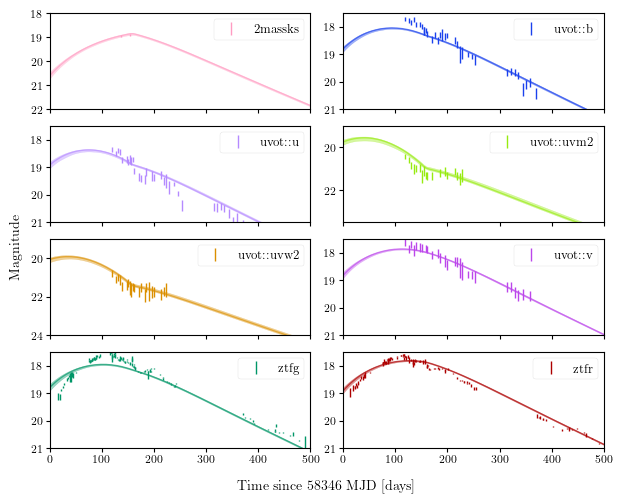

In [18]:
res = redback.result.read_in_result("/content/SN2018ibb_result.json")

fig, axes = plt.subplots(4,2, figsize=(6.6,5),sharex=True)
ax = res.plot_multiband_lightcurve(
    figure=fig, axes=axes,
    save=False, show=False,
    filters=[
        'ztfg', 'ztfr', '2massks',
        'uvot::u', 'uvot::v', 'uvot::b',
        'uvot::uvw2', 'uvot::uvm2'
        ],
    uncertainty_mode='credible_intervals',
    fontsize_figure=10,
    fontsize_legend=9,
    fontsize_ticks=8,
    axis_tick_params_pad=2,
    elinewidth=1, linewidth=1,
    band_colors={
      'ztfg': COLOUR_KEY['green'],
      'ztfr': COLOUR_KEY['red'],
      'uvot::u': COLOUR_KEY['violet'],
      'uvot::b': COLOUR_KEY['blue'],
      'uvot::uvw2': COLOUR_KEY['orange'],
      'uvot::v': COLOUR_KEY['purple'],
      'uvot::uvm2': COLOUR_KEY['limegreen'],
      '2massks': COLOUR_KEY['pink'],},
    set_same_color_per_subplot = True # overrides max_likelihood color and random_sample_color
    )

ax[0].set_xscale('linear')
for x in range(len(ax)):
    ax[x].set_ylim(21, 17.5)
    ax[x].set_xlim(0,500)
ax[0].set_ylim(22, 18)
ax[3].set_ylim(23.5, 19)
ax[4].set_ylim(24, 19)

fig.subplots_adjust(left=0.08, bottom=0.1, right=0.92, wspace=0.125, hspace=0.175)
fig.savefig('/content/plots/ibb.png', dpi=300, bbox_inches='tight')